In [11]:
import os
import warnings
warnings.filterwarnings("ignore", message=".*Your `PyDataset` class should call `super().__init__\\(\\*\\*kwargs\\)`.*")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
#Sayın Hocam kodun neredeyse hepsi 64x64 ile aynı burada değişikleri özetliyim
# 1.Image Dimensions arttırıldı 212x212 yapıldı
# 2.Image Dimension değişiminden kaynaklı değişmesi gereken bazı yerler değiştirildi not düşüldü
# 3.Bir tane daha Conv bloğu eklendi
# 4.Hala tüm modelleri grid searchteki kaydediyor kaydetmesine ama en iyi model hariç siliyor çünkü çok fazla model birikiyordu dosyada
# gerek olduğunu düşünmedim hepsini kaydetmesine.En optimize en iyi model kaydedilicek sadece ismi de buna göre değiştirildi
# Batch size düşürüldü


In [13]:
# Dataset klasör yapısı: class_name/*.jpg
train_dir = "Data_Split/train"  
test_dir = "Data_Split/test"
val_dir = "Data_Split/val"



In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Farklı CNN dosyalarında bu kısım değişecek ve katman sayısı artıcak
img_dimensions = (212, 212)
batch_sz = 16  # Saatlerce sürdüğü için 128x128de,burada düşürme kararı aldım Dataset 2'de bu batch miktarını kullanacağım ve batch size neyi etkiliyor bununla ilgili de yorum yapacağım

basic_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Klasörlerden görsel alımı train - val - ve testler ayrı klasörlerden

train_loader = basic_datagen.flow_from_directory(
    train_dir,
    target_size=img_dimensions,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=True  
)


# Validation set : eğitim sırasında en başarılı modeli bulmak için Grid search yaparken burayı kullanmak için.
#Yöntem 1'de validation set kullanmamıştım düşük doğruluk oranımın sebebi olabilir mi diye test etmek istedim
#Çünkü overfittingden şüpheleniyordum raporumda belirttiğim gibi

val_loader = basic_datagen.flow_from_directory(
    val_dir,
    target_size=img_dimensions,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=False  
)

#test seti : eğitim sonrasında belirlenen en iyi hiperparametreli model için
test_loader = basic_datagen.flow_from_directory(
    test_dir,
    target_size=img_dimensions,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=False
)

#Sunum için Not: Validation set'te amacım overfitting olup olmadığını kontrol edebilmek eğer sürekli shufflelarsam bundan emin olamam ama 
#train ederken shuffelamak mantıklı overfitting engeller

#




Found 9971 images belonging to 5 classes.
Found 2136 images belonging to 5 classes.
Found 2141 images belonging to 5 classes.


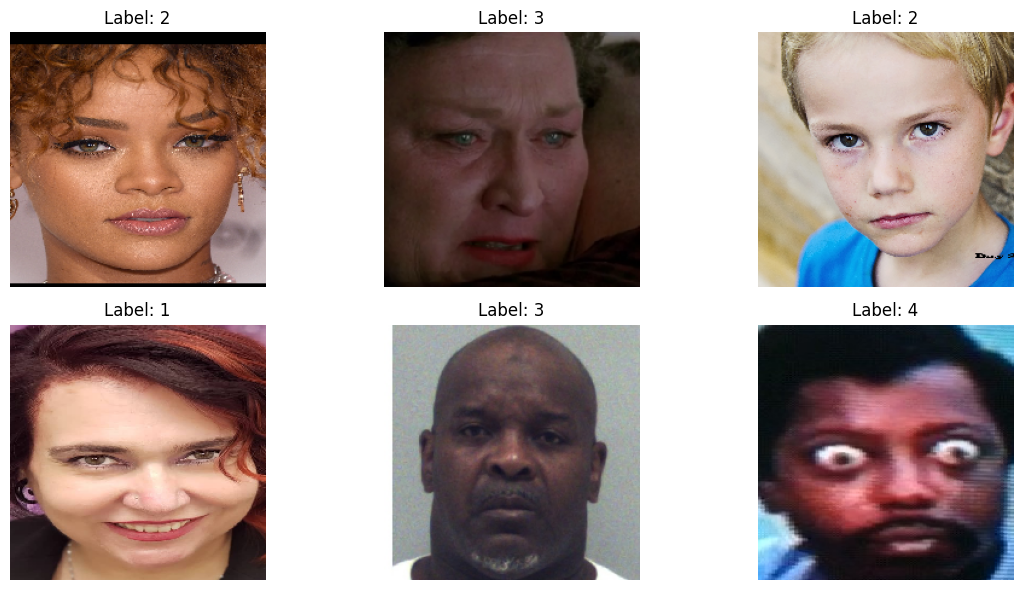

In [15]:
# Img doğru alındı mı kontrolü

images, labels = next(train_loader)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#Sayın Hocam bu adım Yöntem'1de yoktu kısa  bir kontrol amacıyla eklemek istedim

In [16]:
#Hiperparametreler, katmanlar ve ne işe yaradıkları sunum için not
#Katman Türü	Amaç	                              Hiperparametre
#Conv2D	    Kenar, desen çıkarımı	              Filtre sayısı, kernel boyutu
#BatchNorm	Normalize edip öğrenmeyi hızlandırır  Yok
#MaxPooling	Boyut küçültme, öznitelik seçimi	  Havuzlama boyutu
#Dropout	    Aşırı öğrenmeyi engeller	          Dropout oranı
#Dense	    Karar mekanizması	                  Nöron sayısı
#Softmax	    Sınıf tahmini	                      num_classes kadar çıkış

In [19]:
import itertools
import warnings
import os
warnings.filterwarnings("ignore", message=".*Your `PyDataset` class should call `super().__init__\\(\\*\\*kwargs\\)`.*")
#Sayın Hocam Bu warning susturma için not : Aslında kodun eğitimini bozan durduruan bir sıkıntı değil sadece göze batıyor diye kod çalıştırıldığında
#gelen warningi(ImageDataGenerator kullanımı sırasında PyDataset ile ilişkili bir user warning var) onu susturmak için 

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input

# Hyperparametre gridi, çünkü Grid Search ile en iyi hyperparametreleri bulmaya çalışacağız (Toplam 8 tane deneyeceğim)
#Raporumda birkaç hiperparametre için zaten bazı değerler verilmişti ama yani orda bir anlamsızlık olduğunu fark ettim sonuçta en iyi modeli
#aramam gerekiyor

param_options = {
    'filters_1': [32, 64],
    'filters_2': [32],
    'dropout_rate': [0.4, 0.5],
    'dense_units': [128],
    'activation': ['relu', 'tanh'],
    'pool_type': ['max']
}
# daha fazla kombinasyon denemek isterdim ama bilgisayarım yüzünden süre yeterli değil  

# Olabilecek tüm kombinasyonları burada üretiyorum
keys, values = zip(*param_options.items())
sampled_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

experiment_results = []

for i, params in enumerate(sampled_combinations):
    print(f"\n>> CNN Hiperparametre Modeli {i + 1}/8 : {params}")

    net = models.Sequential()
    net.add(Input(shape=(212, 212, 3)))  # GÜNCELLENDİ: 64x64 yerine 128x128 (64x64 dosyasından farkı işte burda)
    # Bir warning alıyordum onu engellemek için fixed bir input salladım

    # Rapordaki sıra işlenmiyor tabii ki aşağıda çünkü sizin verdiğiniz feedback doğrultusunda projeye bu farlı img boyutları resize etme 
    # eklendi aşağıda feedback doğrultusunda 1 Conv bloğu daha ekleniyor  

    # 1. Conv bloğu
    net.add(layers.Conv2D(params['filters_1'], (3, 3), activation=params['activation'], padding='same'))
    net.add(layers.BatchNormalization())
    net.add(layers.MaxPooling2D(pool_size=(2, 2)))  # 128 -> 64

    # 2. Conv bloğu
    net.add(layers.Conv2D(params['filters_2'], (3, 3), activation=params['activation'], padding='same'))
    net.add(layers.BatchNormalization())
    net.add(layers.MaxPooling2D(pool_size=(2, 2)))  # 64 -> 32

    # 3. Conv bloğu
    net.add(layers.Conv2D(params['filters_2'], (3, 3), activation=params['activation'], padding='same'))
    net.add(layers.BatchNormalization())
    net.add(layers.MaxPooling2D(pool_size=(2, 2)))  # 32 -> 16

    # 4. Conv bloğu (yeni eklenen)
    net.add(layers.Conv2D(params['filters_2'] * 2, (3, 3), activation=params['activation'], padding='same'))
    net.add(layers.BatchNormalization())
    net.add(layers.MaxPooling2D(pool_size=(2, 2)))  # 16 -> 8


    # Flatten + Dense
    net.add(layers.GlobalAveragePooling2D()) #Burası değişti bu kodda
    net.add(layers.Dense(params['dense_units'], activation=params['activation']))
    net.add(layers.Dropout(rate=params['dropout_rate']))
    net.add(layers.Dense(train_loader.num_classes, activation='softmax'))

    # Model compile etme aşaması Adam kullanma sebebim şu linktedir : https://keras.io/api/optimizers/adam/
    net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_filename = f"212x212_model_{i + 1}.keras"
    save_callback = ModelCheckpoint(model_filename, monitor='val_accuracy', save_best_only=True, verbose=0)
    early_stop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    # Model eğitimi — Output basmıyor bu hali ile  (verbose=1 yaparak loglara erişilebilir)
    training = net.fit(
        train_loader,
        validation_data=val_loader,
        epochs=30, #Zaten early stop yaptığımız için genelde 30a varmıyor bile yaptığım CNN dosyasında bunu görmüştüm
        callbacks=[save_callback, early_stop_cb],
        verbose=0
    )

    best_val_acc = max(training.history['val_accuracy']) if 'val_accuracy' in training.history else 0.0
    result_entry = {
        'Model': model_filename,
        **params,
        'val_accuracy': best_val_acc
    }
    experiment_results.append(result_entry)

# En iyi modeli bul
top_model = max(experiment_results, key=lambda res: res['val_accuracy'])

print("\n=== En İyi Model Config's ===")
for key, value in top_model.items():
    print(f"{key}: {value}")

# Diğer tüm model dosyalarını siliyorum çünkü 64x64de göstermek için hepsini basıyordum buradan sonraki dosyalarda sadece en iyisi tutulucak 
for result in experiment_results:
    if result["Model"] != top_model["Model"]:
        try:
            os.remove(result["Model"])
        except:
            pass  # dosya yoksa problem etme

# En iyi modeli tekrar kaydet (farklı bir isimle)
from tensorflow.keras.models import load_model
best_cnn = load_model(top_model["Model"])
best_cnn.save("best_model_212x212_overall.keras")  # sadece bunu kullan




    


>> CNN Hiperparametre Modeli 1/8 : {'filters_1': 32, 'filters_2': 32, 'dropout_rate': 0.4, 'dense_units': 128, 'activation': 'relu', 'pool_type': 'max'}

>> CNN Hiperparametre Modeli 2/8 : {'filters_1': 32, 'filters_2': 32, 'dropout_rate': 0.4, 'dense_units': 128, 'activation': 'tanh', 'pool_type': 'max'}

>> CNN Hiperparametre Modeli 3/8 : {'filters_1': 32, 'filters_2': 32, 'dropout_rate': 0.5, 'dense_units': 128, 'activation': 'relu', 'pool_type': 'max'}

>> CNN Hiperparametre Modeli 4/8 : {'filters_1': 32, 'filters_2': 32, 'dropout_rate': 0.5, 'dense_units': 128, 'activation': 'tanh', 'pool_type': 'max'}

>> CNN Hiperparametre Modeli 5/8 : {'filters_1': 64, 'filters_2': 32, 'dropout_rate': 0.4, 'dense_units': 128, 'activation': 'relu', 'pool_type': 'max'}

>> CNN Hiperparametre Modeli 6/8 : {'filters_1': 64, 'filters_2': 32, 'dropout_rate': 0.4, 'dense_units': 128, 'activation': 'tanh', 'pool_type': 'max'}

>> CNN Hiperparametre Modeli 7/8 : {'filters_1': 64, 'filters_2': 32, 'drop

In [20]:
from tensorflow.keras.models import load_model

best_cnn = load_model(top_model["Model"])


In [21]:
best_cnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 212, 212, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 212, 212, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 106, 106, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 106, 106, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 106, 106, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 53, 53, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 53, 53, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,433 (673.57 KB)

 Trainable params: 57,349 (224.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 114,700 (448.05 KB)

In [22]:
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call `super().__init__")
test_loss, test_acc = best_cnn.evaluate(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

c:\Users\Deniz\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.7077 - loss: 0.7685
Test Accuracy: 0.6716


134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step


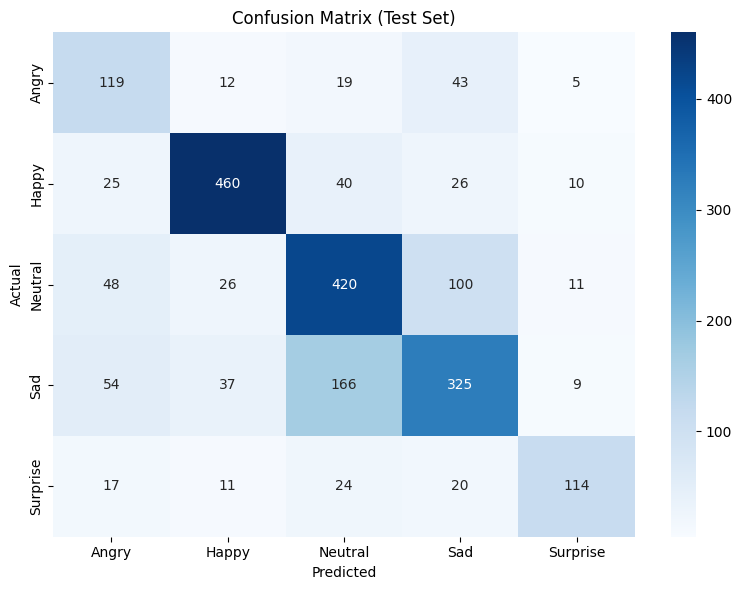

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

true_labels = test_loader.classes

# En iyi modeli kullanarak predict yapıyoruz
predicted_probs = best_cnn.predict(test_loader)  # Note: Test verileri küçük olduğundan uzun sürmicektir hocam bende bile kısa  sürüyor
predicted_labels = np.argmax(predicted_probs, axis=1)  

# COnfusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)


label_names = list(test_loader.class_indices.keys())  

# Plot klasını kullanarak tablo oluşturdum aşağıdaki gibi
plt.figure(figsize=(8, 6))  
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()  # avoids cut-off labels
plt.show()


In [28]:
# Hangi sınıfta ne kadar başarılı olduğunu gösteren detaylı tablo
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(test_loader.class_indices.keys())
))



              precision    recall  f1-score   support

       Angry       0.45      0.60      0.52       198
       Happy       0.84      0.82      0.83       561
     Neutral       0.63      0.69      0.66       605
         Sad       0.63      0.55      0.59       591
    Surprise       0.77      0.61      0.68       186

    accuracy                           0.67      2141
   macro avg       0.66      0.66      0.66      2141
weighted avg       0.68      0.67      0.67      2141

